# Determine optimal number of clusters

In [2]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [15]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

In [11]:
def get_weights_per_segments(
    weights: np.ndarray,
    n_segments: int
) -> np.ndarray:
    """
    Compress explanation weights by averaging over fixed segments.

    Parameters
    ----------
    weights : np.ndarray
        Array of shape (n_samples, n_wavelengths) containing the explanation weights.
    n_segments : int
        Number of segments to divide the wavelength grid into.

    Returns
    -------
    weights_per_segment : np.ndarray
        Compressed array of shape (n_samples, n_segments) where each column
        corresponds to the average weight over a segment.
    """

    n_samples, n_wavelengths = weights.shape

    base_size, residual_size = divmod(n_wavelengths, n_segments)
    if residual_size > 0:
        n_segments += 1

    print(f"Base size: {base_size}, Residual size: {residual_size}")
    print(f"New number of segments: {n_segments}")

    # Create empty array
    weights_per_segment = np.empty((n_samples, n_segments))

    for i in range(n_segments):
        if i < n_segments - 1:
            start = i * base_size
            end = (i + 1) * base_size
        else:
            start = base_size * (n_segments - 1)
            end = n_wavelengths

        # Fill by averaging over the segment
        weights_per_segment[:, i] = weights[:, start:end].mean(axis=1)

    return weights_per_segment

def compute_inertias_silhouette(
    X: np.ndarray, n_clusters: int=10
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the inertia and silhouette score for a range of cluster numbers.
    Parameters
    ----------
    X : np.ndarray
        The data to cluster.
    n_clusters : int
        The maximum number of clusters to consider.
    Returns
    -------
    inertias : np.ndarray
        The inertia values for each number of clusters.
    silhouette_scores : np.ndarray
        The silhouette scores for each number of clusters.
    """ 

    inertias = []
    silhouette_scores = []
    n_clusters_range = range(2, n_clusters)

    start_time = time.perf_counter()
    # Fit the k-means model
    for n in n_clusters_range:
        kmeans = KMeans(n_clusters=n, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        # print(f"n: {n}, inertia: {kmeans.inertia_}", end="\r")
    finish_time = time.perf_counter()
    print(f"Run time: {finish_time - start_time:.2f} seconds")

    return np.array(inertias), np.array(silhouette_scores)


# Data ingestion

In [7]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# MSE

In [8]:
score_name = "mse_noRel100"
explanation_run_id = "20250427190650_uniform_5000_scale"

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

## Unique raw explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 37.67 seconds


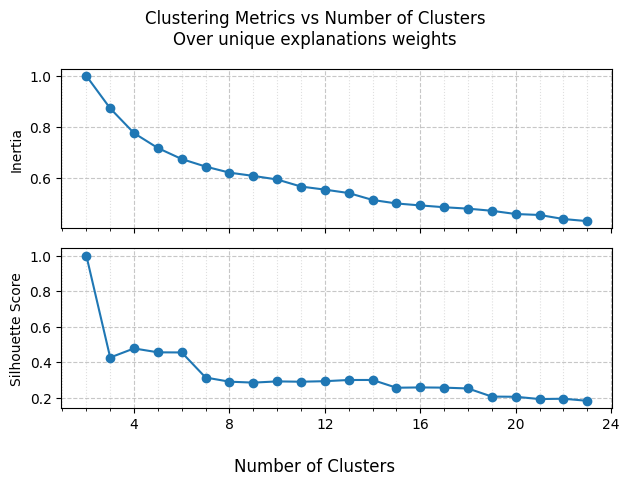

In [ ]:
X = get_weights_per_segments(weights=weights, n_segments=128)

n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_raw_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_raw_unique_weights_{explanation_run_id}.jpeg"
)

# Base size: 29, Residual size: 61
# New number of segments: 129
# Run time: 37.67 seconds

## Absolute value of unique explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 36.61 seconds


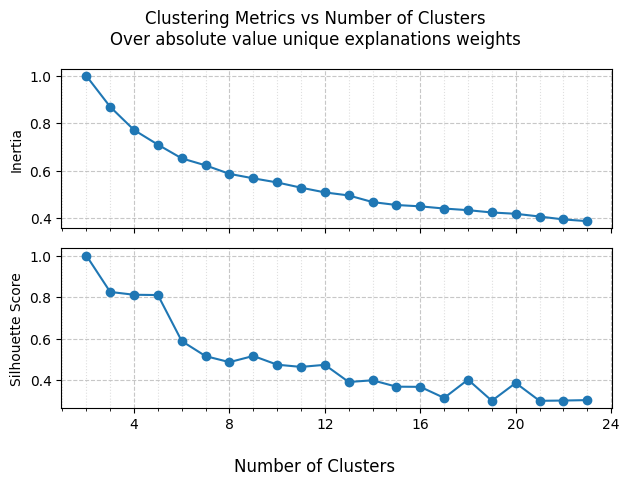

In [ ]:
X = get_weights_per_segments(weights=weights, n_segments=128)
X = np.abs(X)
n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over absolute value unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_abs_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_abs_unique_weights_{explanation_run_id}.jpeg"
)
# Base size: 29, Residual size: 61
# New number of segments: 129
# Run time: 36.61 seconds


## Normalized (row level) absolute value unique explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 38.95 seconds


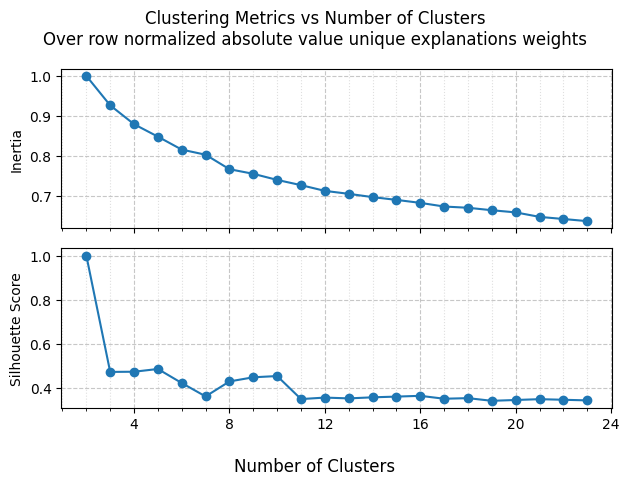

In [19]:
X = get_weights_per_segments(weights=weights, n_segments=128)
X = np.abs(X)/np.max(np.abs(X), axis=1, keepdims=True)

n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over row normalized absolute value unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_norm_row_abs_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_norm_row_abs_unique_weights_{explanation_run_id}.jpeg"
)

# MSE filter 250 kms noRel100

In [20]:
score_name = "mse_filter_250kms_noRel100"
explanation_run_id = "20250427094150_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

## Unique raw explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 37.88 seconds


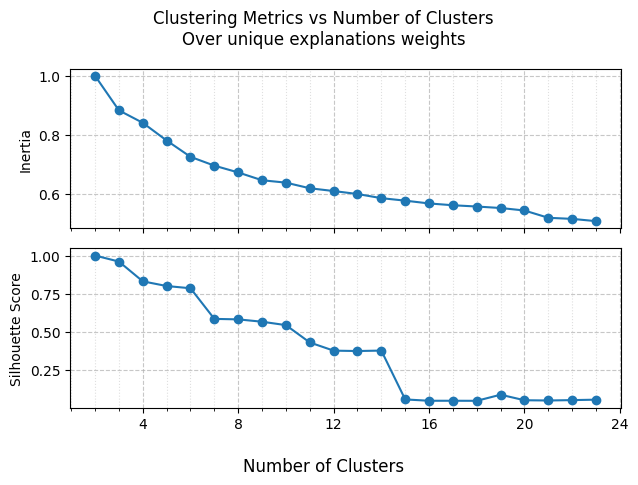

In [ ]:
X = get_weights_per_segments(weights=weights, n_segments=128)

n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_raw_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_raw_unique_weights_{explanation_run_id}.jpeg"
)
# Base size: 29, Residual size: 61
# New number of segments: 129
# Run time: 37.88 seconds


## Absolute value of unique explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 36.97 seconds


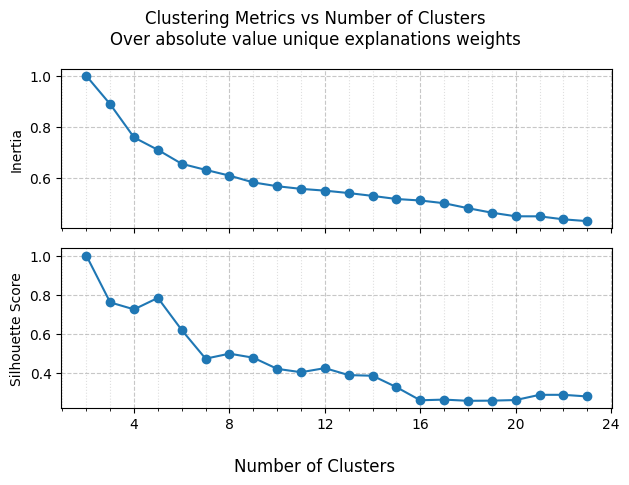

In [22]:
X = get_weights_per_segments(weights=weights, n_segments=128)
X = np.abs(X)
n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over absolute value unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_abs_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_abs_unique_weights_{explanation_run_id}.jpeg"
)


## Normalized (row level) absolute value of unique explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 34.57 seconds


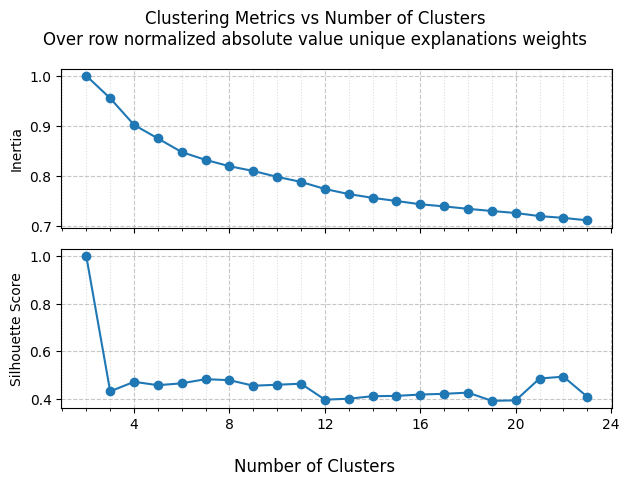

In [ ]:
X = get_weights_per_segments(weights=weights, n_segments=128)
X = np.abs(X)/np.max(np.abs(X), axis=1, keepdims=True)

n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over row normalized absolute value unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_norm_row_abs_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_norm_row_abs_unique_weights_{explanation_run_id}.jpeg"
)
# Base size: 29, Residual size: 61
# New number of segments: 129
# Run time: 34.57 seconds